## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import numpy as np
from sklearn.metrics import recall_score, precision_score

%matplotlib inline

В этом примере мы попробуем предсказать итоговую оценку участинка только на основе **его действий**

In [2]:
df_train = pd.read_csv("../data/raw/train.csv")
df_user = pd.read_csv("../data/raw/user_decision.csv")

## Рассмотрим датасет по ближе

In [3]:
df_train.shape

(681, 5)

In [4]:
df_user.shape

(112643, 3)

In [5]:
df_user.head(3)

,user_id,period,decision_id
0,649,1,10
1,649,1,26
2,649,1,27


In [6]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112643 entries, 0 to 112642
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   user_id      112643 non-null  int64
 1   period       112643 non-null  int64
 2   decision_id  112643 non-null  int64
dtypes: int64(3)
memory usage: 2.6 MB


Заметим что в есть категория где пользватель совершал больше действий

In [7]:
df_user.period.value_counts()

3    36797
4    27092
2    25978
1    18277
5     1940
6      921
8      869
7      769
Name: period, dtype: int64

Пострим на распределение данных

Text(0.5, 1.0, 'Распределение периода')

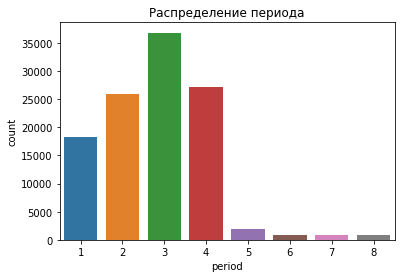

In [8]:
sns.countplot(x = "period" , data  = df_user).set_title('Распределение периода')

Text(0.5, 1.0, 'Распределение действий')

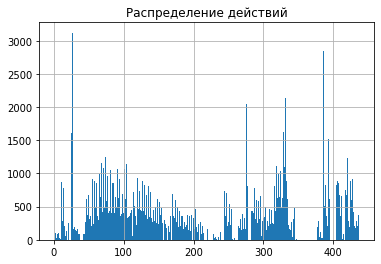

In [9]:
df_user["decision_id"].hist(bins = 300).set_title('Распределение действий')

Text(0.5, 1.0, 'Зависимость действий от игровго периода')

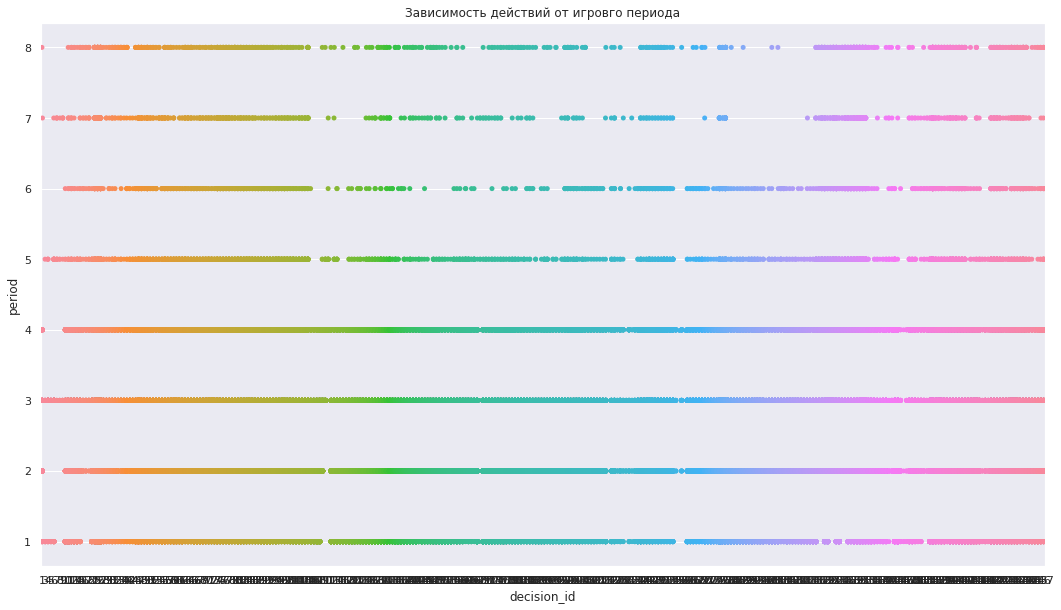

In [14]:
sns.set(rc={'figure.figsize':(18,10)})
sns.stripplot(data = df_user, x= "decision_id", y = "period").set_title('Зависимость действий от игровго периода')

### Добавим новых значений

Узнаем частоту команд участника в каждом периоде

In [38]:
df_user_train = df_user[df_user.user_id.map(lambda x:x in df_train.id.values)]

In [39]:
df_decision_count = df_user_train.groupby(by=["user_id",	"period"]).count()

In [40]:
df_decision_count.head(5)

decision_id
user_id period             
667     1                21
        2                53
        3                36
        4                10
668     1                14

In [76]:
for id in df_train.id.values:
  for period in range(1,5):
    try :
      index = df_train[df_train.id == id].index[0]
      df_train.loc[index,"period_"+str(period)] = df_decision_count.loc[pd.IndexSlice[id, period:period], :].values[0][0]
    except IndexError:
      continue

In [78]:
df_train.head(3)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4
0,985,4.0,4.0,5.0,4.0,40,51.0,52.0,28.0
1,2141,5.0,5.0,4.0,5.0,40,48.0,84.0,38.0
2,1122,4.0,3.0,4.0,4.0,18,NaN,NaN,NaN
3,2058,4.0,4.0,4.0,4.0,1,1.0,1.0,NaN
4,1811,5.0,4.0,5.0,5.0,0,4.0,16.0,13.0


In [82]:
df_train = df_train.fillna(0)

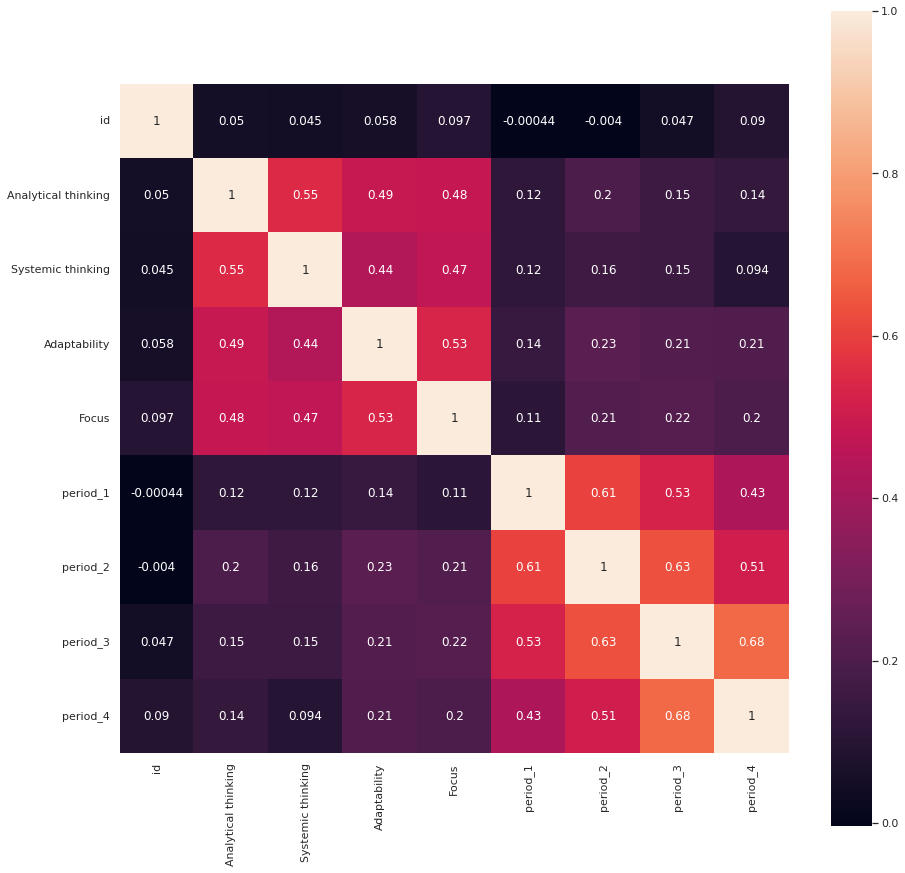

In [84]:
plt.rcParams['figure.figsize']=(15,15)

g = sns.heatmap(df_train.corr(), square = True, annot=True)

## Выделим выборки

In [87]:
X = df_train.drop(["period_1",	"period_2",	"period_3",	"period_4","id"], axis = 1)
y = df_train[["period_1",	"period_2",	"period_3",	"period_4"]]

In [88]:
X.shape

(681, 4)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Обучение модели

In [90]:
clf = RandomForestClassifier(random_state=0)

In [91]:
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

## Оценка точности

In [92]:
pred = clf.predict(X_test)

In [93]:
y_test.head(3)

,period_1,period_2,period_3,period_4
648,8,9.0,3.0,7.0
296,1,0.0,0.0,0.0
63,1,12.0,16.0,9.0


In [99]:
result = 0 

for i in range(4):
  result += recall_score(y_test["period_" + str(i+1)], pred[:,i], average='macro', zero_division=True)

print("Recall score",result/4)

Recall score 0.05414201720810461
